In [27]:
# Importazione delle librerie necessarie
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Caricamento dei dati in un DataFrame (assumiamo che i dati siano in un file CSV)
data = pd.read_csv('data.csv')

# Visualizzazione dei primi 5 record per verificare il caricamento corretto
data.head()

,SampleTime,SensorID,Value
0,0,2,0.033883
1,0,4,-0.009496
2,0,5,0.000000
3,0,7,-0.057306
4,0,8,0.029096


In [28]:
# Sezione 2: Preprocessing del dataset

# Pivot del dataset per avere i sensori come colonne e i tempi come righe
data_pivot = data.pivot(index='SampleTime', columns='SensorID', values='Value')

# Sostituisci i valori NaN con la media della colonna
data_pivot.fillna(data_pivot.mean(), inplace=True)

# Converti il DataFrame in un array numpy
sensor_data = data_pivot.values

# Ottieni il numero di campioni e il numero di sensori
n_samples, n_sensors = sensor_data.shape

In [29]:
# Sezione 3: Definizione del problema di ottimizzazione

# Definisci la matrice di covarianza
cov_matrix = np.cov(sensor_data, rowvar=False)

# Definisci i parametri iniziali
alpha_init = np.ones(n_sensors) / n_sensors

# Definisci il valore di B
B = 10

# Definisci la funzione obiettivo per minimizzare la varianza
def objective_min_variance(alpha):
    return np.dot(alpha.T, np.dot(cov_matrix, alpha))

# Definisci i vincoli
constraints = [{'type': 'eq', 'fun': lambda alpha: np.sum(alpha) - 1},
               {'type': 'ineq', 'fun': lambda alpha: B - np.sum(alpha > 0)}]

# Definisci i limiti per i coefficienti
bounds = [(0, 1) for _ in range(n_sensors)]

In [30]:
# Sezione 4: Risoluzione del problema di minimizzazione della varianza

# Risolvi il problema di ottimizzazione
result_min_variance = minimize(objective_min_variance, alpha_init, bounds=bounds, constraints=constraints)

# Ottieni i coefficienti ottimali per la minimizzazione della varianza
alpha_min_variance = result_min_variance.x

In [31]:
# Sezione 5: Risoluzione del problema di massimizzazione della media

# Calcola la media dei sensori
mean_vector = np.mean(sensor_data, axis=0)

# Definisci la funzione obiettivo per massimizzare la media
def objective_max_mean(alpha):
    return -np.dot(alpha, mean_vector)

# Definisci i nuovi vincoli per la massimizzazione della media
constraints_max_mean = constraints + [{'type': 'ineq', 'fun': lambda alpha: result_min_variance.fun - np.dot(alpha.T, np.dot(cov_matrix, alpha))}]

# Risolvi il problema di ottimizzazione
result_max_mean = minimize(objective_max_mean, alpha_min_variance, bounds=bounds, constraints=constraints_max_mean)

# Ottieni i coefficienti ottimali per la massimizzazione della media
alpha_max_mean = result_max_mean.x

In [32]:
# Sezione 6: Creazione del sensore virtuale

# Calcola i valori del sensore virtuale
virtual_sensor = np.dot(sensor_data, alpha_max_mean)

# Aggiungi il sensore virtuale al DataFrame originale
data_pivot['VirtualSensor'] = virtual_sensor

# Ripristina SampleTime come colonna
data_pivot.reset_index(inplace=True)

# Visualizza le prime righe del DataFrame con il sensore virtuale
data_pivot.head()

SensorID,SampleTime,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,VirtualSensor
0,0,0.00066,0.001024,0.033883,0.000855,-0.009496,0.000000,0.001404,-0.057306,0.029096,...,0.00097,0.000523,-0.031695,0.001209,0.00038,0.000302,0.001725,0.000753,0.000984,0.850547
1,1,0.00066,0.001024,0.015576,0.000855,-0.032448,0.000000,0.001404,-0.031316,-0.014137,...,0.00097,0.000523,-0.017504,0.001209,0.00038,0.000302,0.001725,0.000753,0.000984,1.267348
2,2,0.00066,0.001024,0.026012,0.000855,-0.009146,0.000000,0.001404,0.029068,0.000000,...,0.00097,0.000523,-0.020132,0.001209,0.00038,0.000302,0.001725,0.000753,0.000984,0.868616
3,3,0.00066,0.001024,0.056087,0.000855,-0.029231,0.000000,0.001404,0.014784,0.047547,...,0.00097,0.000523,-0.001091,0.001209,0.00038,0.000302,0.001725,0.000753,0.000984,1.872616
4,4,0.00066,0.001024,0.030423,0.000855,0.001849,0.028083,0.001404,0.003815,-0.012248,...,0.00097,0.000523,0.015896,0.001209,0.00038,0.000302,0.001725,0.000753,0.000984,0.453132


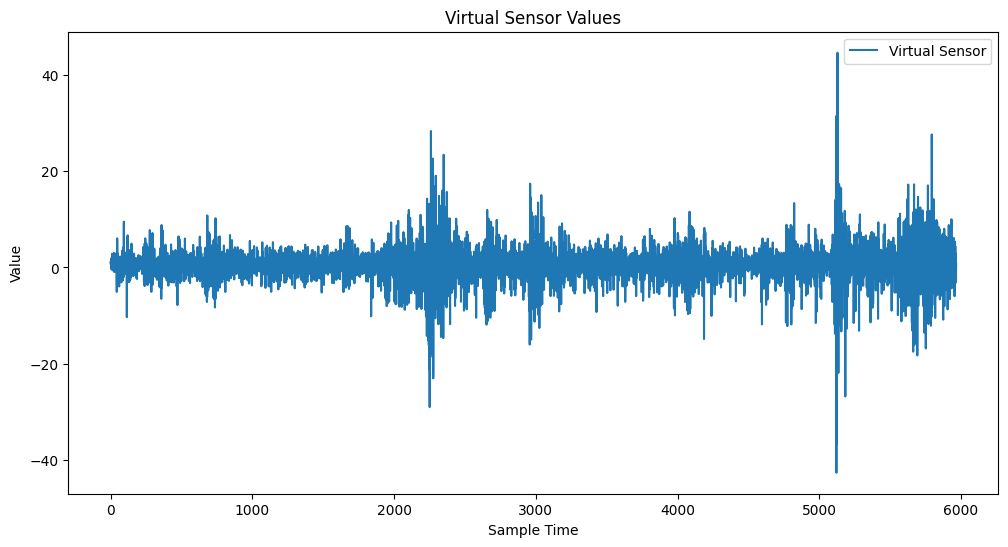

In [34]:
# Sezione 7: Visualizzazione dei risultati

import matplotlib.pyplot as plt

# Plot del sensore virtuale
plt.figure(figsize=(12, 6))
plt.plot(data_pivot['SampleTime'], data_pivot['VirtualSensor'], label='Virtual Sensor')
plt.xlabel('Sample Time')
plt.ylabel('Value')
plt.title('Virtual Sensor Values')
plt.legend()
plt.show()

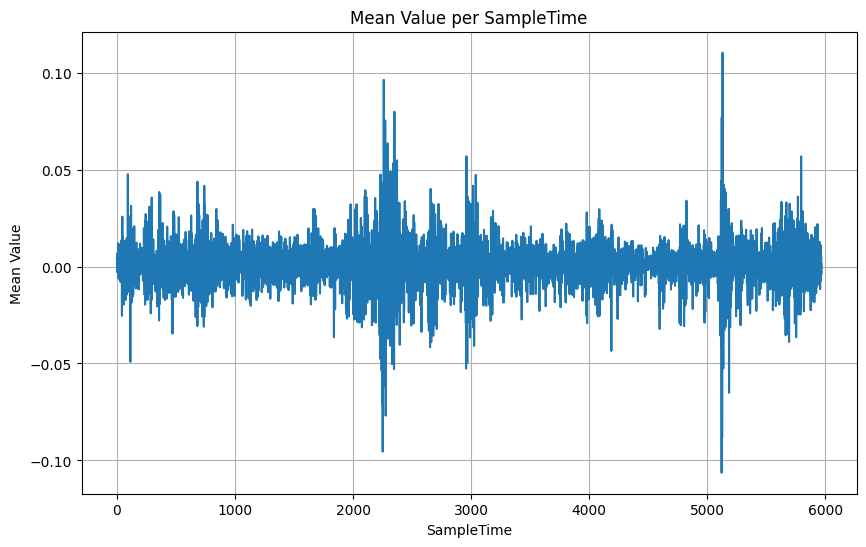

In [35]:
# Calcola la media dei valori per ogni SampleTime
mean_values = data.groupby('SampleTime')['Value'].mean()

# Plot della media dei valori per SampleTime
plt.figure(figsize=(10, 6))
plt.plot(mean_values.index, mean_values.values)
plt.xlabel('SampleTime')
plt.ylabel('Mean Value')
plt.title('Mean Value per SampleTime')
plt.grid(True)
plt.show()